In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from extractors import ResNetV2Extractor
from extractors import ResNetExtractor
from extractors import CIELABKMeansExctractor
from extractors import CIELABPositionalExctractor
from extractors import W2VVExtractor
from extractors import EfficientNetExtractor
from extractors import ViTExtractor
from extractors import ImageGPTExtractor
from extractors import BatchExtractor
from extractors import CLIPExtractor

from transformers import logging

# Disable annoying warnings
logging.set_verbosity_error()

print(tf.__version__)

2.6.1


In [2]:
images_paths = []
with open("v3c1/frame-ID-to-filepath.V3C1.csv") as file:
    images_paths = file.readlines()
    images_paths = ["v3c1/thumbs/" + line.rstrip() for line in images_paths]
images_paths[:3]

['v3c1/thumbs/00000/v00000_s00000(f00000000-f00000012)_f00000006.jpg',
 'v3c1/thumbs/00000/v00000_s00001(f00000018-f00000199)_f00000019.jpg',
 'v3c1/thumbs/00000/v00000_s00001(f00000018-f00000199)_f00000038.jpg']

In [ ]:
extractors = []

In [3]:
#extractor = CIELABPositionalExctractor(regions=(4,8), aggType="medoid-approx")
#extractor = W2VVExtractor(use_gpu=False, batch_size=8)
#extractor = ResNetV2Extractor(size="152")
#extractor = ResNetExtractor(size="50")
#extractor = EfficientNetExtractor(size="0")
#extractor = ViTExtractor()
extractor = BatchExtractor(batch_size=1, extractor=ImageGPTExtractor())
#extractor = CLIPExtractor()

In [4]:
def l2_dist(a, b):
    return np.linalg.norm(a - b)
    
def cos_dist(a, b):
    a = a / np.linalg.norm(a, axis=-1)
    b = b / np.linalg.norm(b, axis=-1)
    return 1 - np.dot(a,b)

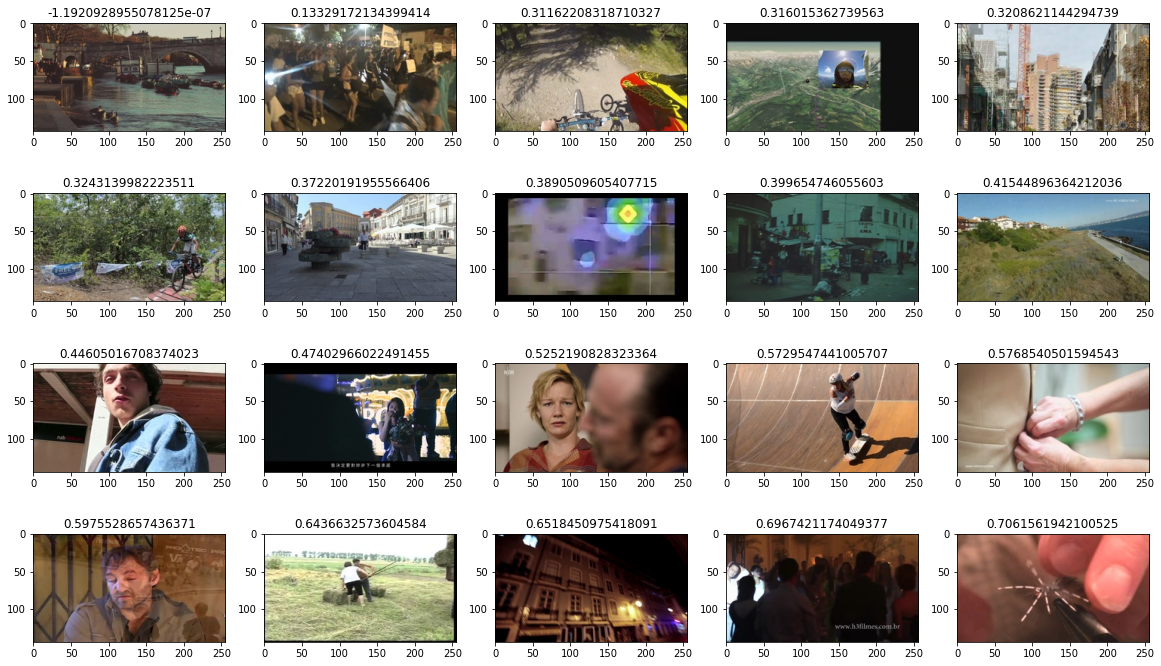

In [5]:
np.random.seed(11)
image_ids = np.random.randint(0, high=len(images_paths), size=(20,))

image_features = extractor([images_paths[img_id] for img_id in image_ids])

fig, axes = plt.subplots(ncols=5, nrows=image_ids.shape[0] // 5, figsize=(20,image_features.shape[0] * 6 // 10))

for ax, (img_id, idx) in zip([item for sublist in axes for item in sublist], sorted(zip(image_ids, range(image_ids.shape[0])), 
                              key=lambda tup: cos_dist(image_features[0], image_features[tup[1]]))):
    ax.set_title(cos_dist(image_features[0], image_features[idx]))
    ax.imshow(mpimg.imread(images_paths[img_id]))

plt.show()

In [6]:
from sklearn.cluster import KMeans
from skimage import io
from skimage import color

In [7]:
rgb = io.imread(images_paths[123])
lab = color.rgb2lab(rgb)
lab.reshape((-1, 3))

array([[44.75009587, 13.94751229, -4.10293804],
       [45.95567059, 13.88100861, -4.09446784],
       [47.35634379, 14.76284903, -5.57371618],
       ...,
       [36.09781474, -2.67781893,  3.66167724],
       [36.93862539, -2.66766227,  3.64686286],
       [36.09781474, -2.67781893,  3.66167724]])

In [21]:
kmeans = KMeans(n_clusters=8).fit(lab.reshape((-1, 3)))

In [24]:
feats = kmeans.cluster_centers_
display(feats)
scores = np.linalg.norm(feats, axis=1)
print(scores)
display(feats[np.argsort(scores)])

array([[16.91125222, 16.66808738, -7.06638624],
       [50.05395376,  0.95812776,  3.56173627],
       [65.20708311,  3.076127  ,  0.07795188],
       [31.75560781, 12.76363841, -2.76510425],
       [35.8309685 ,  0.24430186,  3.85596332],
       [50.76899045,  8.88801186, -7.85508716],
       [40.19995262, 20.36615108,  4.09140188],
       [24.13501346, 15.1082221 , -4.81291337]])

[24.77396624 50.18966289 65.27964707 34.33620385 36.03867978 52.13625937
 45.24992674 28.87769701]


array([[16.91125222, 16.66808738, -7.06638624],
       [24.13501346, 15.1082221 , -4.81291337],
       [31.75560781, 12.76363841, -2.76510425],
       [35.8309685 ,  0.24430186,  3.85596332],
       [40.19995262, 20.36615108,  4.09140188],
       [50.05395376,  0.95812776,  3.56173627],
       [50.76899045,  8.88801186, -7.85508716],
       [65.20708311,  3.076127  ,  0.07795188]])

In [28]:
lab.shape

(144, 256, 3)

In [8]:
arr = lab[:36,:64].reshape((-1,3))
dist_mat = np.linalg.norm(arr.reshape((-1,1,3)) - arr.reshape((1,-1,3)), axis=-1)
dist_mat.shape

(2304, 2304)

In [6]:


from transformers import ImageGPTFeatureExtractor, ImageGPTModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = ImageGPTFeatureExtractor.from_pretrained("openai/imagegpt-small")
model = ImageGPTModel.from_pretrained("openai/imagegpt-small")
model.to(device)



Some weights of the model checkpoint at openai/imagegpt-small were not used when initializing ImageGPTModel: ['lm_head.weight']
- This IS expected if you are initializing ImageGPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ImageGPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ImageGPTModel(
  (wte): Embedding(513, 512)
  (wpe): Embedding(1024, 512)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): ImageGPTBlock(
      (ln_1): ImageGPTLayerNorm()
      (attn): ImageGPTAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): ImageGPTLayerNorm()
      (mlp): ImageGPTMLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): ImageGPTBlock(
      (ln_1): ImageGPTLayerNorm()
      (attn): ImageGPTAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): ImageGPTLayerNorm()
      (mlp): ImageGPTMLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )

In [7]:
from PIL import Image
import requests

images = [Image.open(images_paths[img_id]) for img_id in image_ids[:1]]

encoding = feature_extractor(images, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)



torch.Size([1, 1024])


In [8]:
# forward pass
outputs = model(pixel_values, output_hidden_states=True)
hidden_states = outputs.hidden_states
print(len(hidden_states))

25


In [10]:
feature_vector = torch.mean(hidden_states[len(hidden_states) // 2], dim=1)
feature_vector.shape

torch.Size([1, 512])

In [11]:
np.stack([np.array([[1,2,3]])])

array([[[1, 2, 3]]])